# Financial Econometrics - Homework 3
Dimitrios TERESSONOK - B00763957
Semen MANUSHKO - B00760363
William TAN - B00762546 
___________________________________________________________________

In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import norm, ks_2samp
from pandas_datareader import data
from tqdm import tqdm


## Question 1

In [2]:
Ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']
Ticker = Ticker.str.replace(".",'-')
Ticker = pd.DataFrame(Ticker)

In [3]:
final_list = []
start_date, end = '1984-01-01', '2019-12-30'
factors = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV",sep=',',header=2)
lenfact = factors.shape[0]
factors = factors[0:lenfact-1]
factors = factors.rename(columns={'Unnamed: 0':'X'})
factors['X'] = pd.to_datetime(factors['X'].astype(str))
factorsA = factors[factors['X'] > start_date]
factorsA = factorsA.reset_index()
factorsA = factorsA.drop(['index'], axis=1)

In [5]:
print(factorsA.tail())

              X  Mkt-RF   SMB   HML   RMW   CMA     RF
9069 2019-12-23    0.10  0.16 -0.28 -0.12  0.31  0.007
9070 2019-12-24    0.01  0.36 -0.07 -0.28  0.02  0.007
9071 2019-12-26    0.49 -0.56  0.00  0.23 -0.19  0.007
9072 2019-12-27   -0.09 -0.54 -0.07  0.24  0.16  0.007
9073 2019-12-30   -0.57  0.27  0.58  0.15  0.45  0.007


In [5]:
T = len(Ticker)
for i in tqdm(range(T)):
    extr = data.DataReader(Ticker.iloc[i][0], 'yahoo', start_date, end)
    extr['Log'] = np.log(extr['Adj Close'])
    Returns = np.diff(extr['Log'])
    extr['Returns'] = np.append(0,Returns)
    extr = extr.reset_index()

    factorsB = factorsA
    if len(extr) != len(factorsA):
        factorsB = factorsA[factorsA['X'] >= extr.Date[0]]

    factorsB = factorsB.reset_index()
    factorsB = factorsB.drop(['X', 'index'], axis=1)
    extr = pd.concat([extr, factorsB], axis=1)
    extr = extr.iloc[1:,:]
    Ri_Rf1 = extr['Returns'] - extr['RF']
    X = extr[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X, y = X.values, Ri_Rf1.values
    X = sm.add_constant(X)
    result = sm.OLS(y, X).fit()
    r2 = result.rsquared
    t_val = result.tvalues[0]
    final_list.append([Ticker.iloc[i][0], result.params[0], result.params[1], result.params[2],
                 result.params[3], result.params[4], result.params[5], t_val, r2])

df = pd.DataFrame(final_list, columns=['Ticker', 'Const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'T_Val_Const', 'R2'])
df

 82%|█████████████████████████████████████████████████████████████████▋              | 415/505 [21:11<03:09,  2.10s/it]C:\Users\William\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [25:28<00:00,  3.03s/it]


,Ticker,Const,Mkt-RF,SMB,HML,RMW,CMA,T_Val_Const,R2
0,MMM,-0.013404,0.009556,-0.001232,-0.000197,0.003969,0.005074,-83.087439,0.280511
1,ABT,-0.013045,0.008424,-0.002579,-0.004522,0.006119,0.005433,-71.356049,0.210891
2,ABBV,-0.002716,0.010319,-0.000704,-0.005302,-0.002590,0.002054,-7.421202,0.261338
3,ABMD,-0.011664,0.010842,0.008926,-0.003576,-0.006554,0.001138,-25.396607,0.108226
4,ACN,-0.004783,0.008998,-0.000694,-0.003413,-0.003988,-0.001043,-19.873786,0.310930
...,...,...,...,...,...,...,...,...,...
500,YUM,-0.007479,0.009041,0.001435,-0.000326,0.005312,0.002604,-30.981652,0.228512
501,ZBRA,-0.009416,0.009654,0.006732,-0.002773,-0.001065,-0.002012,-32.419543,0.198053
502,ZBH,-0.005107,0.007903,0.000884,-0.001506,0.001323,0.000437,-22.256971,0.248615
503,ZION,-0.013543,0.011028,0.005040,0.018274,-0.002094,-0.007890,-59.522624,0.333110


## Question 2

In [6]:
df.describe()

,Const,Mkt-RF,SMB,HML,RMW,CMA,T_Val_Const,R2
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,-0.009824,0.010257,0.002324,0.001218,0.000478,0.000101,-42.155362,0.250655
std,0.003946,0.002291,0.003200,0.005522,0.004895,0.004862,24.025818,0.098370
min,-0.013964,0.000596,-0.004344,-0.010514,-0.020753,-0.018711,-88.556002,0.002838
25%,-0.013335,0.008680,0.000029,-0.002130,-0.001420,-0.002275,-63.479099,0.181332
50%,-0.011626,0.010319,0.002130,0.000313,0.001826,0.000962,-42.821532,0.244282
75%,-0.006500,0.011886,0.004693,0.003740,0.003558,0.003550,-18.822432,0.310600
max,-0.001460,0.017119,0.011063,0.021700,0.013529,0.009794,-3.546225,0.628074


## Question 3

C:\Users\William\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\William\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


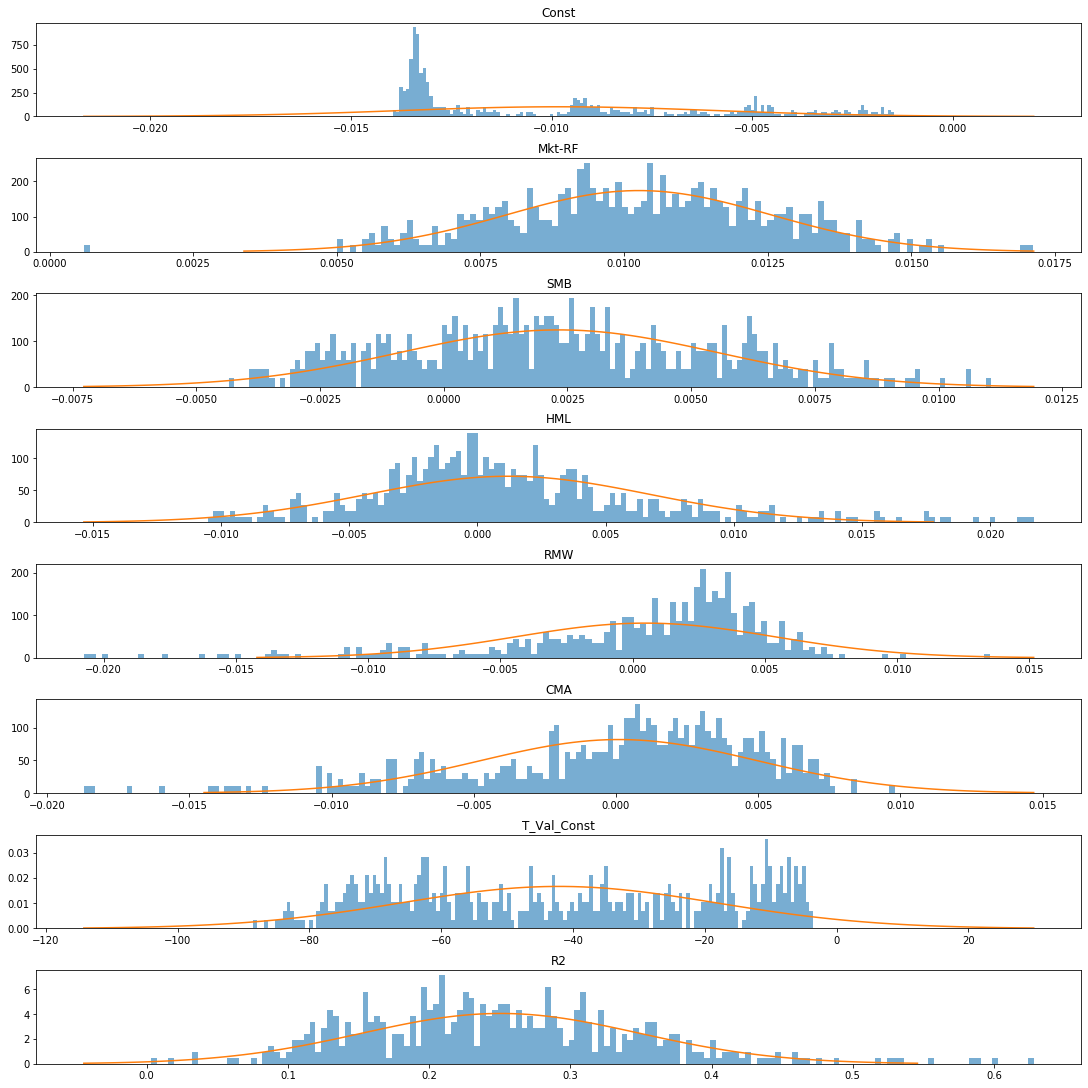

In [7]:
get_info = list(df.columns)[1:]
fig, ax = plt.subplots(nrows=len(get_info),constrained_layout=True,figsize=(15,15))

for i in range(len(get_info)):
    ax[i].hist(df[get_info[i]], bins=150, density=True, alpha=0.6) 
    mu, sigma= df[get_info[i]].mean(), df[get_info[i]].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax[i].plot(x, stats.norm.pdf(x, mu, sigma))
    ax[i].set_title(get_info[i])
plt.show()

## Question 4

<b>Five companies with the highest constant</b>

In [8]:
df.sort_values(by='Const', ascending=False).head(5)

,Ticker,Const,Mkt-RF,SMB,HML,RMW,CMA,T_Val_Const,R2
79,AVGO,-0.001460,0.012040,0.001859,-0.002971,-0.000755,-0.005981,-4.200659,0.328225
102,CHTR,-0.001462,0.008321,-0.001556,-0.001991,-0.000994,0.000301,-4.742724,0.205157
475,V,-0.001581,0.009379,-0.001943,-0.000103,-0.003010,-0.006423,-6.161144,0.441731
201,FTNT,-0.001619,0.010507,0.004369,-0.006967,-0.005035,-0.007041,-3.830970,0.263718
196,FLT,-0.001624,0.009317,0.002040,-0.001113,-0.002343,-0.002190,-5.248454,0.299128


<b>Five companies with the lowest constant</b>

In [9]:
df.sort_values(by='Const').head(5)

,Ticker,Const,Mkt-RF,SMB,HML,RMW,CMA,T_Val_Const,R2
33,AIG,-0.013964,0.013420,-0.003737,0.014633,-0.003994,-0.005306,-49.469166,0.280447
52,ARNC,-0.013941,0.014084,0.002592,0.004112,0.001731,0.004496,-62.895179,0.319735
491,WY,-0.013900,0.012142,0.000037,0.003513,0.002727,0.004364,-61.830513,0.250743
240,HST,-0.013831,0.014304,0.006685,0.010809,0.004532,-0.002330,-60.743845,0.342967
255,IP,-0.013804,0.012752,0.001241,0.005276,0.002617,0.003470,-68.674856,0.320550


# Question 5

We will consider momentum as the 6th factor. For this one, we will do the difference between the average percentage return of the portfolio of the 5 highest momentum stocks and the average percentage return of the portfolio of the 5 lowest momentum stocks. Momentum will be calculated on a 5-day basis using the following formula:

<b> M = ln(Price Today) - ln(Price Five Days Ago)</b>

In [27]:
final_list = []
T = len(Ticker)

for i in tqdm(range(T)):
    extr = data.DataReader(Ticker.iloc[i][0], 'yahoo', start_date, end)
    extr['Log'] = np.log(extr['Adj Close'])
    Returns = np.diff(extr['Log'])
    extr['Returns'] = np.append(0,Returns)
    
    momentum = np.diff(extr['Log'], n=2)
    extr['Momentum'] = np.append([0, 0],momentum)
    extr = extr.iloc[6:]
    
    extr = extr.reset_index()

    factorsB = factorsA
    if len(extr) != len(factorsA):
        factorsB = factorsA[factorsA['X'] >= extr.Date[0]]

    factorsB = factorsB.reset_index()
    factorsB = factorsB.drop(['X', 'index'], axis=1)
    extr = pd.concat([extr, factorsB], axis=1)
    extr = extr.iloc[1:,:]
    Ri_Rf1 = extr['Returns'] - extr['RF']
    X = extr[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA','Momentum']]
    X, y = X.values, Ri_Rf1.values
    X = sm.add_constant(X)
    result = sm.OLS(y, X, missing='drop').fit()
    r2 = result.rsquared
    t_val = result.tvalues[0]
    final_list.append([Ticker.iloc[i][0], result.params[0], result.params[1], result.params[2],
                 result.params[3], result.params[4], result.params[5], result.params[6], t_val, r2])

new_df = pd.DataFrame(final_list, columns=['Ticker', 'Const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Momentum', 'T_Val_Const', 'R2'])
new_df

 82%|████████▏ | 415/505 [08:31<02:02,  1.36s/it]/Users/semen/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 505/505 [11:36<00:00,  2.14s/it]


,Ticker,Const,Mkt-RF,SMB,HML,RMW,CMA,Momentum,T_Val_Const,R2
0,MMM,-0.013198,0.005887,-0.000124,-0.000086,0.002001,0.002483,0.367546,-91.155032,0.421100
1,ABT,-0.012851,0.004965,-0.000685,-0.002697,0.003863,0.002156,0.416335,-82.317794,0.424914
2,ABBV,-0.002436,0.006055,-0.000666,-0.003015,-0.002708,0.002684,0.421000,-8.480470,0.548045
3,ABMD,-0.011523,0.005508,0.006600,-0.001929,-0.004677,0.000779,0.474100,-35.715218,0.560588
4,ACN,-0.004641,0.005103,-0.000591,-0.001840,-0.003219,-0.002187,0.399290,-24.011111,0.556195
...,...,...,...,...,...,...,...,...,...,...
500,YUM,-0.007287,0.004946,0.001202,0.000224,0.002809,0.000516,0.422868,-37.107241,0.490426
501,ZBRA,-0.009231,0.005023,0.004271,-0.001563,-0.002265,-0.001509,0.442925,-41.421312,0.527799
502,ZBH,-0.004944,0.004344,0.000323,-0.000308,0.000371,-0.000957,0.414934,-26.460735,0.501114
503,ZION,-0.013330,0.006528,0.003266,0.011260,-0.001975,-0.005282,0.383816,-70.863207,0.544559


In [28]:
new_df.describe()

,Const,Mkt-RF,SMB,HML,RMW,CMA,Momentum,T_Val_Const,R2
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,-0.009616,0.005796,0.001871,0.000917,-0.000529,-0.000886,0.414418,-49.863196,0.506680
std,0.003927,0.001576,0.001933,0.003505,0.003514,0.003038,0.038129,27.456155,0.067775
min,-0.013714,-0.000730,-0.004530,-0.006292,-0.016948,-0.013312,0.263708,-97.585696,0.303087
25%,-0.013118,0.004690,0.000518,-0.001195,-0.001704,-0.002278,0.390510,-74.476905,0.463682
50%,-0.011422,0.005658,0.001826,0.000442,0.000486,-0.000403,0.418737,-52.217630,0.508217
75%,-0.006449,0.006867,0.003145,0.002560,0.001708,0.001296,0.440822,-22.298631,0.551086
max,-0.001203,0.011284,0.007313,0.015442,0.010973,0.006183,0.574216,-3.991008,0.719702


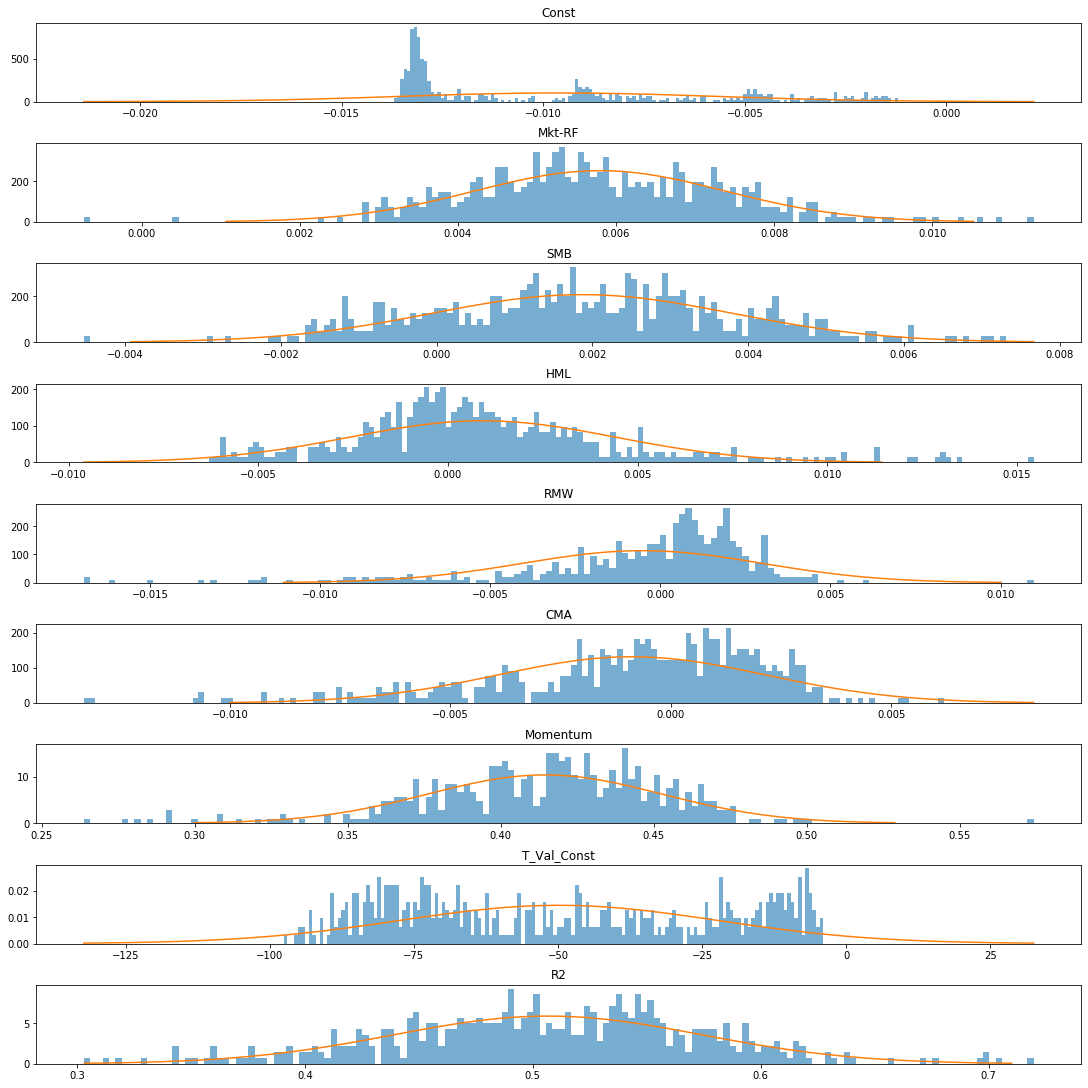

In [29]:
get_info = list(new_df.columns)[1:]
fig, ax = plt.subplots(nrows=len(get_info),constrained_layout=True,figsize=(15,15))

for i in range(len(get_info)):
    ax[i].hist(new_df[get_info[i]], bins=150, density=True, alpha=0.6) 
    mu, sigma= new_df[get_info[i]].mean(), new_df[get_info[i]].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax[i].plot(x, stats.norm.pdf(x, mu, sigma))
    ax[i].set_title(get_info[i])
plt.show()

<b>Five companies with the highest constant</b>

In [30]:
new_df.sort_values(by='Const', ascending=False).head(5)

,Ticker,Const,Mkt-RF,SMB,HML,RMW,CMA,Momentum,T_Val_Const,R2
79,AVGO,-0.001203,0.007301,0.000955,-0.002259,-0.000419,-0.002356,0.400729,-4.436183,0.592000
102,CHTR,-0.001239,0.004540,-0.000692,-0.001430,-0.000548,0.000721,0.439960,-5.268461,0.539030
201,FTNT,-0.001393,0.006195,0.002979,-0.004105,-0.002299,-0.003737,0.423757,-4.326416,0.574603
475,V,-0.001414,0.005465,-0.001570,0.000033,-0.003356,-0.005132,0.360546,-7.091971,0.656385
196,FLT,-0.001464,0.005299,0.001130,-0.000785,-0.001289,-0.001130,0.406607,-6.055909,0.570852


<b>Five companies with the lowest constant</b>

In [31]:
new_df.sort_values(by='Const').head(5)

,Ticker,Const,Mkt-RF,SMB,HML,RMW,CMA,Momentum,T_Val_Const,R2
33,AIG,-0.013714,0.007732,-0.002011,0.008709,-0.003500,-0.004379,0.389400,-56.626912,0.471077
52,ARNC,-0.013654,0.008407,0.002576,0.002986,-0.000179,0.001330,0.377742,-71.822795,0.500437
491,WY,-0.013628,0.007079,0.001298,0.002094,0.000807,0.001250,0.413284,-73.310540,0.488420
112,C,-0.013598,0.010078,-0.000707,0.013046,-0.003849,-0.010687,0.308457,-68.726294,0.573151
240,HST,-0.013552,0.008794,0.004991,0.006585,0.002493,-0.002340,0.382068,-72.105147,0.553095
